# The Perfect Score
> This notebook was part of Udacity's Data Analyst Nanodegree. It demonstrates the effects of data leakage on a prediction.
> Three models achieved perfect scores of 100% accuracy due to data leakage of the imputer.

## Table of Contents
<ul>
<li><a href="#leak">Data Leak</a></li>
<li><a href="#scores">Scores</a></li>
</ul>

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.preprocessing import Imputer, Normalizer
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.regression.linear_model import OLS
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import model_selection
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tester import dump_classifier_and_data, test_classifier
from testerFast import  test_classifier_fast
from feature_format import featureFormat, targetFeatureSplit
from sklearn.svm import LinearSVC
from scipy.stats import skew
from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline as sk_pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, SelectFpr
from sklearn.base import ClassifierMixin


SEED = 5678
np.random.seed(SEED)

C:\Users\Me\Anaconda3\envs\udacity_ml\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Functions

In [5]:
#prepares data for tester returns a list of column names and dict of values
def tester_prep(dfn):
    features_list = dfn.columns.values
    data_dict = dfn.to_dict('index')
    return features_list, data_dict

# Task 1: Select what features you'll use.

In [6]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
len(data_dict)

146

In [7]:
#convert to df
df = pd.DataFrame.from_dict(data_dict, orient = 'index')
raw_df = df.copy()
df.shape

(146, 21)

In [8]:
# not using this
df.drop(['email_address'], axis = 1, inplace = True)

<a id='leak'></a>

# Impute Missing Data
> This is where the data leakage occurs


In [9]:
#convert to numeric 
cols = df.columns
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [10]:
# not_cols are all the feature columns from the dataset, poi_cols is all the columns except director_fees and 
# restricted_stock_deferred. These columns contain no inforamtion so cannot be used in the imputer

not_cols =[ 'to_messages', 'from_messages', 'from_this_person_to_poi',  
             'from_poi_to_this_person', 'salary',  'deferral_payments', 'total_payments',
           'exercised_stock_options', 'bonus', 'restricted_stock',
           'shared_receipt_with_poi', 'restricted_stock_deferred',
           'total_stock_value', 'expenses', 'loan_advances', 
           'other', 'director_fees', 'deferred_income', 'long_term_incentive']

poi_cols =[ 'to_messages', 'from_messages', 'from_this_person_to_poi',  
             'from_poi_to_this_person', 'salary',  'deferral_payments', 'total_payments',
               'exercised_stock_options', 'bonus', 'restricted_stock',
               'shared_receipt_with_poi', 
               'total_stock_value', 'expenses', 'loan_advances', 
               'other',  'deferred_income', 'long_term_incentive']

# no values in poi data
empty_cols = ['director_fees','restricted_stock_deferred']

In [11]:
imputer_poi = Imputer(missing_values='NaN', strategy = 'mean', axis=0)
imputer_not = Imputer(missing_values='NaN', strategy = 'mean', axis=0)

### This is the exact spot the leak occured. Splitting the data by label before imputing the mean causes a leak by
### using values that are supposed to be unknown in the calculation of the mean.

In [12]:
poi_df = df[df['poi'] == True]
not_df = df[df['poi'] == False]

not_df.loc[: , not_cols] = imputer_not.fit_transform(not_df.loc[: , not_cols])
poi_df.loc[: , poi_cols] = imputer_poi.fit_transform(poi_df.loc[: , poi_cols])

In [13]:
poi_df[empty_cols] = poi_df[empty_cols].fillna(value = 0, axis = 0)

In [14]:
df = pd.concat([poi_df, not_df],axis = 0)
df.shape

(146, 20)

In [15]:
y = df['poi'].copy()
df.drop(['poi'], axis = 1, inplace = True)
print(y.shape, df.shape)

((146L,), (146, 19))


In [16]:
df.isnull().values.any()

False

# Task 2: Remove outliers

In [17]:
ols_mod = OLS(endog = y.values, exog = df)
ols_result = ols_mod.fit()

In [18]:
out_test = ols_result.outlier_test()['bonf(p)']

In [19]:
outliers = list(out_test[out_test<1e-3].index) 

outliers

['LAY KENNETH L', 'BELFER ROBERT', 'TOTAL']

In [20]:
inf = OLSInfluence(ols_result)
stud = inf.resid_studentized_internal
less_outliers = list(stud[stud < -1 ].index)  
more_outliers = list(stud[stud > 1 ].index) 
print(less_outliers, more_outliers)

(['LAY KENNETH L', 'RICE KENNETH D', 'BELFER ROBERT', 'CHAN RONNIE', 'DERRICK JR. JAMES V', 'GRAMM WENDY L', 'MEYER JEROME J', 'PEREIRA PAULO V. FERRAZ', 'POWERS WILLIAM', 'URQUHART JOHN A', 'WAKEHAM JOHN'], ['BELDEN TIMOTHY N', 'BOWEN JR RAYMOND M', 'RIEKER PAULA H', 'SHELBY REX', 'SKILLING JEFFREY K', 'YEAGER F SCOTT', 'BANNANTINE JAMES M', 'BHATNAGAR SANJAY', 'FREVERT MARK A', 'KAMINSKI WINCENTY J', 'KISHKILL JOSEPH G', 'PICKERING MARK R', 'SHAPIRO RICHARD S', 'TOTAL', 'WESTFAHL RICHARD K'])


In [21]:
inf = OLSInfluence(ols_result)
stud = inf.resid_studentized_internal
less_outliers = list(stud[stud < -1 ].index) #0.9 
more_outliers = list(stud[stud > 1 ].index)

In [22]:
print(len(y.loc[more_outliers]))
print(y.loc[more_outliers])

15
BELDEN TIMOTHY N        True
BOWEN JR RAYMOND M      True
RIEKER PAULA H          True
SHELBY REX              True
SKILLING JEFFREY K      True
YEAGER F SCOTT          True
BANNANTINE JAMES M     False
BHATNAGAR SANJAY       False
FREVERT MARK A         False
KAMINSKI WINCENTY J    False
KISHKILL JOSEPH G      False
PICKERING MARK R       False
SHAPIRO RICHARD S      False
TOTAL                  False
WESTFAHL RICHARD K     False
Name: poi, dtype: bool


In [23]:
print(len(raw_df.loc[(raw_df['poi'] == True)]))

18


In [24]:
print(len(y.loc[less_outliers]))
print(y.loc[less_outliers])

11
LAY KENNETH L               True
RICE KENNETH D              True
BELFER ROBERT              False
CHAN RONNIE                False
DERRICK JR. JAMES V        False
GRAMM WENDY L              False
MEYER JEROME J             False
PEREIRA PAULO V. FERRAZ    False
POWERS WILLIAM             False
URQUHART JOHN A            False
WAKEHAM JOHN               False
Name: poi, dtype: bool


In [25]:
drop_list = set(df.loc[less_outliers].index )
drop_list.update(df.loc[['TOTAL']].index)
drop_list.update(df.loc[['THE TRAVEL AGENCY IN THE PARK']].index)
drop_list.update(df.loc[['KAMINSKI WINCENTY J']].index)
#drop_list.update(df.loc[more_outliers].index)
print(drop_list)

set(['LAY KENNETH L', 'TOTAL', 'RICE KENNETH D', 'THE TRAVEL AGENCY IN THE PARK', 'URQUHART JOHN A', 'DERRICK JR. JAMES V', 'GRAMM WENDY L', 'PEREIRA PAULO V. FERRAZ', 'KAMINSKI WINCENTY J', 'WAKEHAM JOHN', 'CHAN RONNIE', 'BELFER ROBERT', 'POWERS WILLIAM', 'MEYER JEROME J'])


In [26]:
df.drop(drop_list, axis = 0, inplace = True)

print(df.shape, y.shape)

((132, 19), (146L,))


In [27]:
y.drop(drop_list, axis = 0, inplace = True)
print(df.shape, y.shape)

((132, 19), (132L,))


In [28]:
y.value_counts()

False    116
True      16
Name: poi, dtype: int64

## -------------------------------------Data Transformations -----------------------------------------------------

In [ ]:
print(df.mean(axis=0), df.std(axis=0))

In [29]:
#Scale the Data
sc = preprocessing.StandardScaler()
scaled_df = sc.fit_transform(df)

In [30]:
col = df.columns.values
df = pd.DataFrame(scaled_df, columns = col)
#print(n_df.mean(axis=0), n_df.std(axis=0))

In [31]:
print(df.mean(axis=0), df.std(axis=0))

(salary                       1.682156e-17
to_messages                 -3.115143e-16
deferral_payments            5.374489e-16
total_payments               7.737918e-17
exercised_stock_options      1.160688e-16
bonus                        2.977416e-16
restricted_stock             5.382900e-17
shared_receipt_with_poi     -9.777532e-17
restricted_stock_deferred   -1.198536e-16
total_stock_value            6.560409e-17
expenses                     1.324698e-16
loan_advances                3.397955e-16
from_messages                4.373606e-17
other                       -3.280204e-17
from_this_person_to_poi     -3.889986e-18
director_fees               -1.555994e-16
deferred_income             -3.355901e-16
long_term_incentive         -2.556877e-16
from_poi_to_this_person      2.691450e-17
dtype: float64, salary                       1.00381
to_messages                  1.00381
deferral_payments            1.00381
total_payments               1.00381
exercised_stock_options      1.00381


## df_all used in tester.py

In [33]:
y.head()

BELDEN TIMOTHY N        True
BOWEN JR RAYMOND M      True
CALGER CHRISTOPHER F    True
CAUSEY RICHARD A        True
COLWELL WESLEY          True
Name: poi, dtype: bool

In [34]:
y.reset_index(drop = True, inplace = True)

In [35]:
#alll data
df_all = pd.concat([y, df ], axis = 1)
df_all.shape

(132, 20)

# Task 3: Create new feature(s) 

### MODELS for features
#### Test Several Models

QDA: 0.000000 (0.000000)
GPC: 0.000000 (0.000000)
KNN: 0.960000 (0.080000)
DTC: 1.000000 (0.000000)
GNB: 0.960000 (0.080000)
SVM: 0.851429 (0.077512)
ABC: 1.000000 (0.000000)
MLP: 0.910000 (0.111355)
RID: 1.000000 (0.000000)
log: 1.000000 (0.000000)


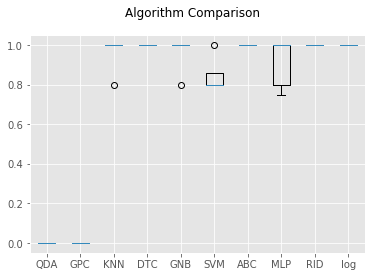

In [51]:
models = []
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('GPC', GaussianProcessClassifier(1.0 * RBF(1.0),random_state = SEED)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(random_state = SEED)))
models.append(('GNB', GaussianNB()))
models.append(('SVM', SVC(random_state = SEED)))
models.append(('ABC', AdaBoostClassifier(random_state = SEED)))
models.append(('MLP', MLPClassifier( random_state = SEED, max_iter=1000)))
models.append(('RID', RidgeClassifier(random_state = SEED)))
models.append(('log', LogisticRegression(random_state = SEED)))

# test and plot all models in models list<a id='scores'></a>
def test_models(models, data, target):
    results = []
    names = []
    scoring = 'f1'

    for name, model in models:
        kfold = StratifiedKFold(n_splits=5, random_state=SEED)
        cv_results = model_selection.cross_val_score(model, data, target, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        #classification_metrics(y_val, rfc_pred)

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()


#run test 

test_models(models, df, y)


<a id='scores'></a>
# Results 
> In the above chart it appears as though four classifiers achieved perfect scores, but logistic regression 
> had 84 false positives out of 14,000 predictions on the confirmation below, the other three models were 14,000 out of 14,000. Confirmation was done using tester.py.

In [38]:
# tester.py
model = AdaBoostClassifier(random_state = SEED)
feat, dat = tester_prep(df_all)
test_classifier(model, dat, feat)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=5678)
	Accuracy: 1.00000	Precision: 1.00000	Recall: 1.00000	F1: 1.00000	F2: 1.00000
	Total predictions: 14000	True positives: 2000	False positives:    0	False negatives:    0	True negatives: 12000



In [45]:
# tester.py
model = DecisionTreeClassifier(random_state = SEED)
feat, dat = tester_prep(df_all)
test_classifier(model, dat, feat)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=5678,
            splitter='best')
	Accuracy: 1.00000	Precision: 1.00000	Recall: 1.00000	F1: 1.00000	F2: 1.00000
	Total predictions: 14000	True positives: 2000	False positives:    0	False negatives:    0	True negatives: 12000



In [46]:
# tester.py
model = RidgeClassifier(random_state = SEED)
feat, dat = tester_prep(df_all)
test_classifier(model, dat, feat)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=5678, solver='auto',
        tol=0.001)
	Accuracy: 1.00000	Precision: 1.00000	Recall: 1.00000	F1: 1.00000	F2: 1.00000
	Total predictions: 14000	True positives: 2000	False positives:    0	False negatives:    0	True negatives: 12000



In [47]:
# Fast TESTER with pipe
model = LogisticRegression(random_state = SEED)
feat, dat = tester_prep(df_all)
test_classifier(model, dat, feat)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=5678, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
	Accuracy: 0.99400	Precision: 0.95969	Recall: 1.00000	F1: 0.97943	F2: 0.99167
	Total predictions: 14000	True positives: 2000	False positives:   84	False negatives:    0	True negatives: 11916

